# Module 1 - Exercise 3: PCA Implementation from Scratch

<a href="https://colab.research.google.com/github/jumpingsphinx/jumpingsphinx.github.io/blob/main/notebooks/module1-linear-algebra/exercise3-pca.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

By the end of this exercise, you will be able to:

- Implement Principal Component Analysis (PCA) from scratch
- Understand eigenvalue decomposition and its role in PCA
- Reduce dimensionality of real datasets
- Interpret principal components and explained variance
- Visualize high-dimensional data in 2D/3D
- Compare your implementation with sklearn's PCA

## Prerequisites

- Completion of Exercises 1 and 2
- Understanding of eigenvalues and eigenvectors
- Covariance matrix concepts

## Setup

Run this cell first to import required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_digits
from sklearn.decomposition import PCA as SklearnPCA
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

print("NumPy version:", np.__version__)
print("Setup complete!")

NumPy version: 1.26.4
Setup complete!


---

## Part 1: Understanding Covariance

### Background

PCA is based on the covariance matrix, which measures how features vary together:
- Diagonal elements: variance of each feature
- Off-diagonal elements: covariance between feature pairs
- Positive covariance: features increase together
- Negative covariance: one increases as the other decreases

### Exercise 1.1: Compute Covariance Matrix

**Task:** Given a dataset with 2 features:

1. Center the data (subtract mean)
2. Compute the covariance matrix manually
3. Compute it using `np.cov()`
4. Verify both methods match

In [2]:
# Sample data: 5 samples, 2 features
data = np.array([[1, 2],
                 [2, 3],
                 [3, 5],
                 [4, 6],
                 [5, 8]])

# Your code here
# Step 1: Center the data
mean = data.mean(axis=0)
centered_data = data - mean

# Step 2: Manual covariance calculation
# Cov = (1/(n-1)) * X^T @ X where X is centered
n = centered_data.shape[0]
cov_manual = (1 / (n - 1)) * (centered_data.T @ centered_data)

# Step 3: Using NumPy (rowvar=False means columns are variables)
cov_numpy = np.cov(data, rowvar=False)

# Verify
assert np.allclose(cov_manual, cov_numpy), "Manual and NumPy covariance should match"
print("\n✓ Covariance calculation correct!")


✓ Covariance calculation correct!


---

## Part 2: Eigenvalue Decomposition

### Background

Eigenvalues and eigenvectors are key to PCA:
- **Eigenvector**: Direction of a principal component
- **Eigenvalue**: Amount of variance explained by that component
- For covariance matrix C: **C v = λ v**

### Exercise 2.1: Compute Eigenvalues and Eigenvectors

**Task:**

1. Compute eigenvalues and eigenvectors of the covariance matrix
2. Sort them by eigenvalue (descending)
3. Verify that eigenvectors are orthogonal
4. Verify the eigenvalue equation: C v = λ v

In [3]:
# Sample covariance matrix
C = np.array([[2.5, 1.5],
              [1.5, 1.5]])

# Your code here
# Step 1: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(C)

# Step 2: Sort by eigenvalue (descending)
idx = eigenvalues.argsort()[::-1]
eigenvalues_sorted = eigenvalues[idx]
eigenvectors_sorted = eigenvectors[:, idx]

# Step 3: Check orthogonality (dot product should be ~0)
dot_product = np.dot(eigenvectors_sorted[:, 0], eigenvectors_sorted[:, 1])

# Step 4: Verify Cv = λv for first eigenvector
v1 = eigenvectors_sorted[:, 0]
lambda1 = eigenvalues_sorted[0]
left_side = C @ v1
right_side = lambda1 * v1

# Verify
assert np.allclose(dot_product, 0, atol=1e-10), "Eigenvectors should be orthogonal"
assert np.allclose(left_side, right_side), "Should satisfy Cv = λv"
print("\n✓ Eigenvalue decomposition correct!")


✓ Eigenvalue decomposition correct!


---

## Part 3: Visualize Principal Components

### Exercise 3.1: Plot Data and Principal Components

**Task:** Visualize how principal components align with data variance.

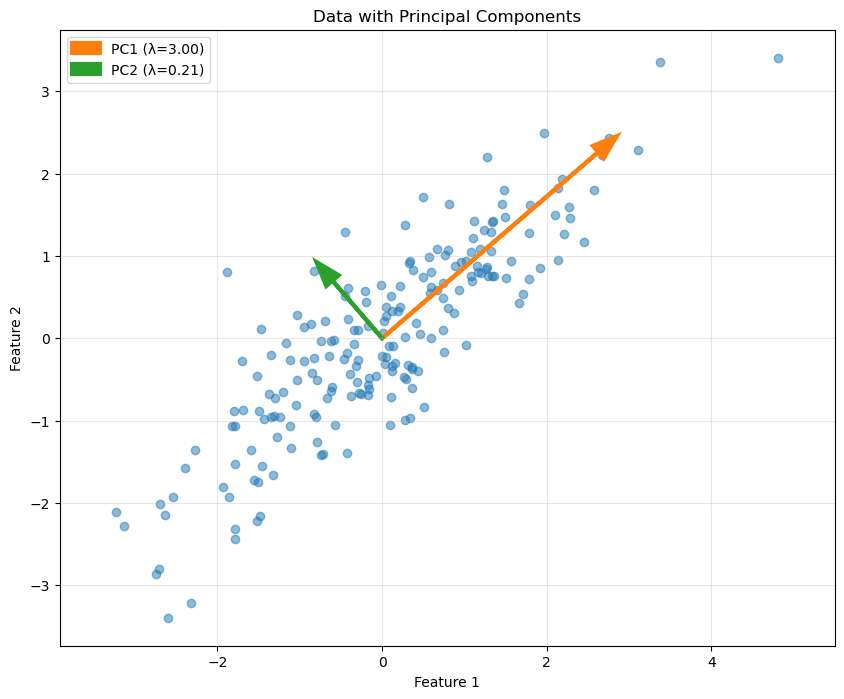

PC1 explains 93.4% of variance
PC2 explains 6.6% of variance


In [4]:
# Generate correlated 2D data
np.random.seed(42)
mean = [0, 0]
cov = [[2, 1.5], [1.5, 1.5]]
data_2d = np.random.multivariate_normal(mean, cov, 200)

# Center the data
data_centered = data_2d - data_2d.mean(axis=0)

# Compute covariance and eigenvectors
cov_matrix = np.cov(data_centered, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort by eigenvalue
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.5)

# Plot principal components as arrows
origin = [0, 0]
for i in range(2):
    # Scale eigenvectors by sqrt of eigenvalue for visualization
    direction = eigenvectors[:, i] * np.sqrt(eigenvalues[i]) * 2
    plt.arrow(origin[0], origin[1], direction[0], direction[1],
              head_width=0.2, head_length=0.3, fc=f'C{i+1}', ec=f'C{i+1}',
              linewidth=3, label=f'PC{i+1} (λ={eigenvalues[i]:.2f})')

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data with Principal Components')
plt.legend()
plt.show()

print(f"PC1 explains {eigenvalues[0]/eigenvalues.sum()*100:.1f}% of variance")
print(f"PC2 explains {eigenvalues[1]/eigenvalues.sum()*100:.1f}% of variance")

---

## Part 4: Implement PCA from Scratch

### Background

PCA algorithm:
1. Center the data (subtract mean)
2. Compute covariance matrix
3. Compute eigenvalues and eigenvectors
4. Sort by eigenvalue (descending)
5. Select top k eigenvectors
6. Project data onto these eigenvectors

### Exercise 4.1: Complete PCA Implementation

**Task:** Implement a PCA class from scratch.

In [5]:
class PCA:
    def __init__(self, n_components=2):
        """
        Principal Component Analysis.
        """
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.eigenvalues_ = None
    
    def fit(self, X):
        """
        Fit PCA on data X.
        """
        # Step 1: Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Step 2: Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # Step 3: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # Step 4: Sort by eigenvalue (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Step 5: Select top k eigenvectors
        self.components_ = eigenvectors[:, :self.n_components]
        self.eigenvalues_ = eigenvalues[:self.n_components]
        
        return self
    
    def transform(self, X):
        """
        Project data onto principal components.
        """
        # Step 1: Center the data
        X_centered = X - self.mean_
        
        # Step 2: Project onto principal components
        # X (n, d) @ components (d, k) -> (n, k)
        X_transformed = np.dot(X_centered, self.components_)
        
        return X_transformed
    
    def fit_transform(self, X):
        """
        Fit and transform in one step.
        """
        self.fit(X)
        return self.transform(X)
    
    def explained_variance_ratio(self):
        """
        Return the proportion of variance explained by each component.
        """
        total_var = np.sum(self.eigenvalues_)
        return self.eigenvalues_ / total_var

print("PCA class implemented!")

PCA class implemented!


---

## Part 5: Test Your PCA Implementation

### Exercise 5.1: Apply PCA to 2D Data

**Task:** Test your PCA on synthetic 2D data.

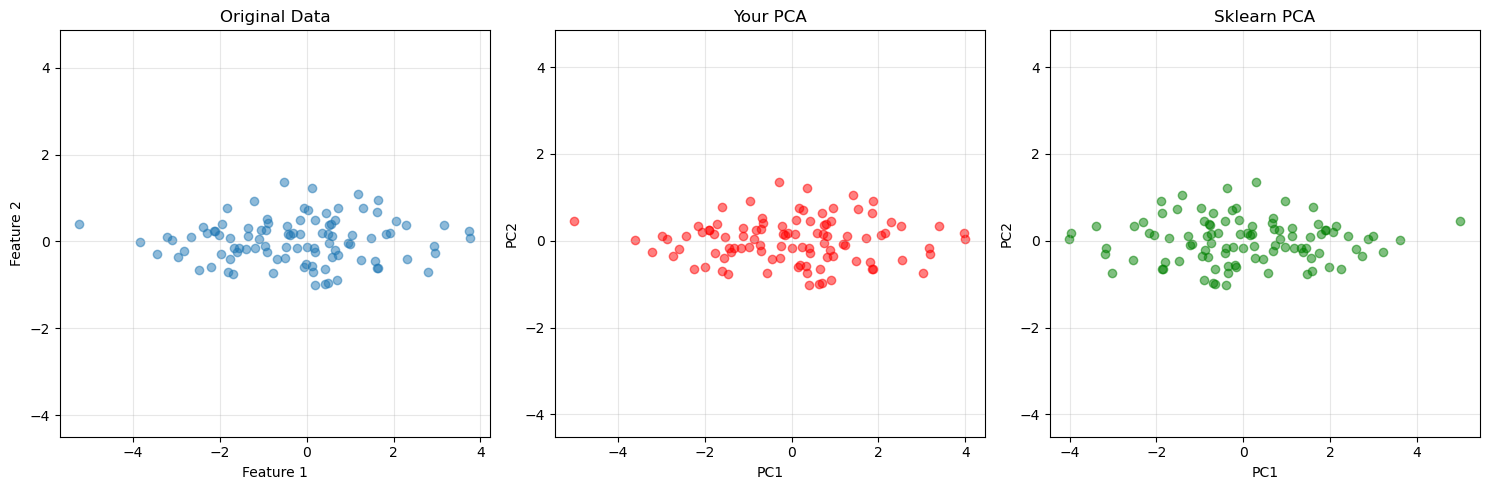

Your explained variance ratios: [0.92171458 0.07828542]
Sklearn explained variance ratios: [0.92171458 0.07828542]

✓ Your PCA works correctly!


In [6]:
# Generate 2D data
np.random.seed(42)
X = np.random.randn(100, 2) @ np.array([[2, 0], [0, 0.5]])

# Apply your PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply sklearn's PCA
sklearn_pca = SklearnPCA(n_components=2)
X_sklearn = sklearn_pca.fit_transform(X)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data
axes[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
axes[0].set_title('Original Data')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Your PCA
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color='red')
axes[1].set_title('Your PCA')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Sklearn PCA
axes[2].scatter(X_sklearn[:, 0], X_sklearn[:, 1], alpha=0.5, color='green')
axes[2].set_title('Sklearn PCA')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Your explained variance ratios:", pca.explained_variance_ratio())
print("Sklearn explained variance ratios:", sklearn_pca.explained_variance_ratio_)

# Verify (note: eigenvectors can point in opposite directions)
assert np.allclose(np.abs(X_pca), np.abs(X_sklearn), atol=0.1), "Results should be similar"
print("\n✓ Your PCA works correctly!")

---

## Part 6: PCA on Iris Dataset

### Background

The Iris dataset has 4 features. We'll use PCA to reduce it to 2D for visualization.

### Exercise 6.1: Dimensionality Reduction

**Task:**

1. Load the Iris dataset
2. Apply PCA to reduce from 4D to 2D
3. Visualize the 2D projection with class labels
4. Analyze explained variance

Iris dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']


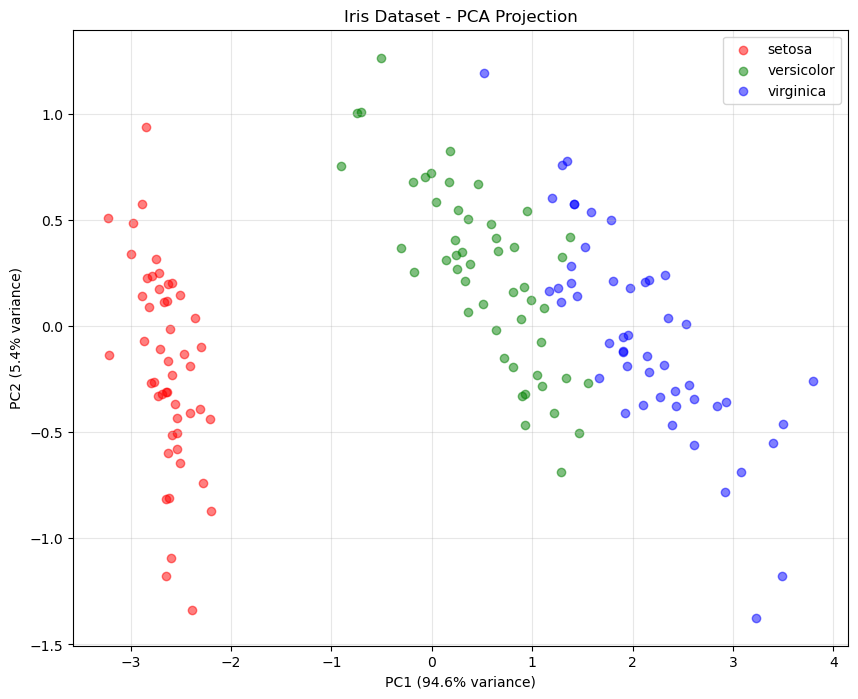


Total variance explained by 2 components: 100.0%


In [7]:
# Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names = iris.target_names

print("Iris dataset shape:", X_iris.shape)
print("Features:", iris.feature_names)
print("Classes:", target_names)

# Apply your PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris)

# Visualize
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i, color, target_name in zip(range(3), colors, target_names):
    plt.scatter(X_pca[y_iris == i, 0], X_pca[y_iris == i, 1],
                color=color, alpha=0.5, label=target_name)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio()[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio()[1]*100:.1f}% variance)')
plt.title('Iris Dataset - PCA Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

total_variance = sum(pca.explained_variance_ratio())
print(f"\nTotal variance explained by 2 components: {total_variance*100:.1f}%")

---

## Part 7: Choosing Number of Components

### Exercise 7.1: Scree Plot

**Task:** Create a scree plot to determine optimal number of components.

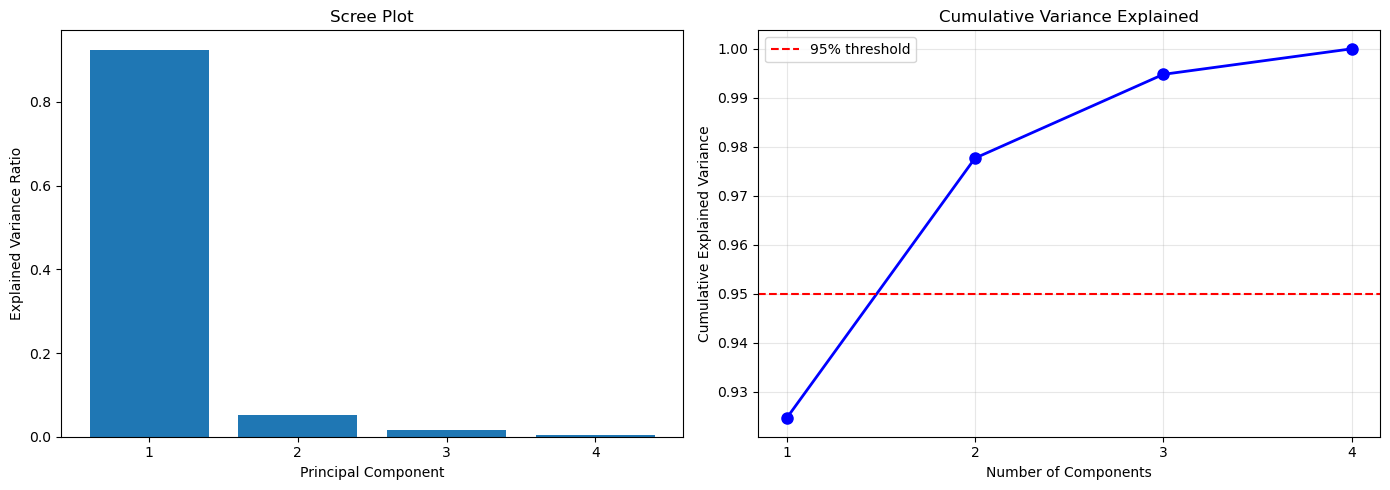

PC1: 92.5% (cumulative: 92.5%)
PC2: 5.3% (cumulative: 97.8%)
PC3: 1.7% (cumulative: 99.5%)
PC4: 0.5% (cumulative: 100.0%)


In [8]:
# Fit PCA with all components
pca_full = PCA(n_components=4)
pca_full.fit(X_iris)

explained_variance = pca_full.explained_variance_ratio()
cumulative_variance = np.cumsum(explained_variance)

# Create scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
axes[0].bar(range(1, 5), explained_variance)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].set_xticks(range(1, 5))

# Cumulative explained variance
axes[1].plot(range(1, 5), cumulative_variance, 'bo-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xticks(range(1, 5))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var*100:.1f}% (cumulative: {cum_var*100:.1f}%)")

---

## Part 8: PCA on High-Dimensional Data

### Exercise 8.1: Digits Dataset (64D → 2D)

**Task:** Apply PCA to the digits dataset (64 features → 2 for visualization).

Digits dataset shape: (1797, 64)
Original dimensionality: 64


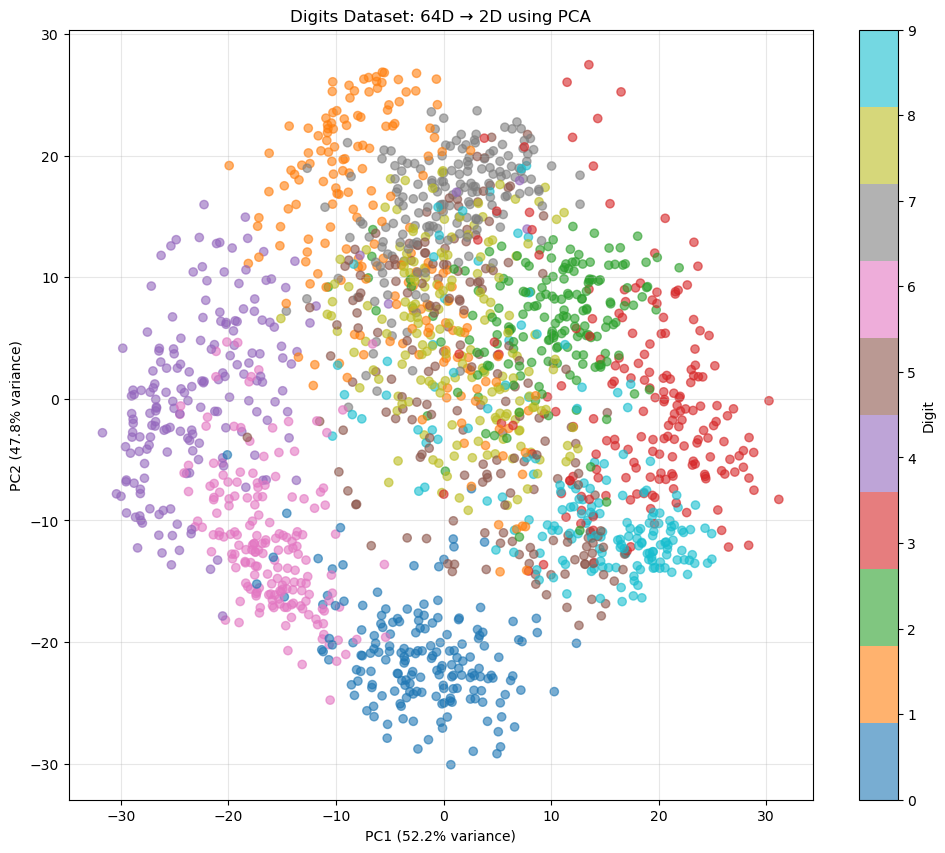


Total variance explained: 100.0%


In [9]:
# Load digits dataset
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print("Digits dataset shape:", X_digits.shape)
print("Original dimensionality:", X_digits.shape[1])

# Apply PCA
pca_digits = PCA(n_components=2)
X_digits_pca = pca_digits.fit_transform(X_digits)

# Visualize
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_digits_pca[:, 0], X_digits_pca[:, 1],
                      c=y_digits, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit')
plt.xlabel(f'PC1 ({pca_digits.explained_variance_ratio()[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_digits.explained_variance_ratio()[1]*100:.1f}% variance)')
plt.title('Digits Dataset: 64D → 2D using PCA')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTotal variance explained: {sum(pca_digits.explained_variance_ratio())*100:.1f}%")

---

## Part 9: PCA for Data Compression

### Exercise 9.1: Reconstruct Data from PCA

**Task:** Use PCA to compress and reconstruct digit images.

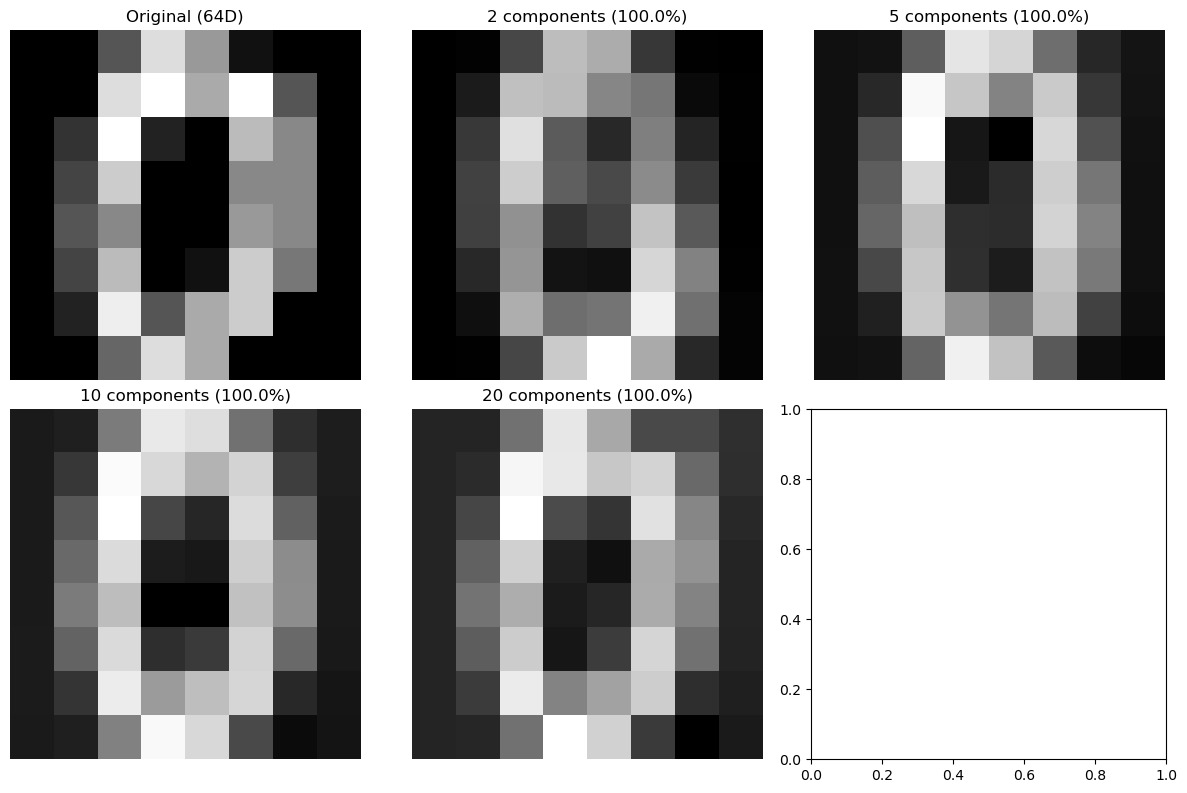

Notice how reconstruction quality improves with more components!


In [10]:
# Select one digit image
idx = 0
original_image = X_digits[idx].reshape(8, 8)

# Try different numbers of components
n_components_list = [2, 5, 10, 20, 64]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

# Original
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original (64D)')
axes[0].axis('off')

# Reconstructions with different numbers of components
for i, n_comp in enumerate(n_components_list[:-1]):
    pca_temp = PCA(n_components=n_comp)
    X_compressed = pca_temp.fit_transform(X_digits)
    
    # Reconstruct: X_reconstructed = X_compressed @ components + mean
    X_reconstructed = X_compressed @ pca_temp.components_.T + pca_temp.mean_
    
    reconstructed_image = X_reconstructed[idx].reshape(8, 8)
    
    axes[i+1].imshow(reconstructed_image, cmap='gray')
    var_explained = sum(pca_temp.explained_variance_ratio()) * 100
    axes[i+1].set_title(f'{n_comp} components ({var_explained:.1f}%)')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print("Notice how reconstruction quality improves with more components!")

---

## Part 10: Compare with Sklearn

### Exercise 10.1: Validate Your Implementation

**Task:** Compare your PCA with sklearn's on multiple metrics.

In [11]:
# Generate test data
np.random.seed(42)
X_test = np.random.randn(100, 5)

# Your PCA
pca_yours = PCA(n_components=3)
X_yours = pca_yours.fit_transform(X_test)

# Sklearn PCA
pca_sklearn = SklearnPCA(n_components=3)
X_sklearn = pca_sklearn.fit_transform(X_test)

# Compare results
print("=" * 60)
print("COMPARISON: Your PCA vs Sklearn PCA")
print("=" * 60)

print("\n1. Explained Variance Ratio:")
print("   Your PCA:", pca_yours.explained_variance_ratio())
print("   Sklearn: ", pca_sklearn.explained_variance_ratio_)
print("   Match?", np.allclose(pca_yours.explained_variance_ratio(), 
                                pca_sklearn.explained_variance_ratio_))

print("\n2. Principal Components (first PC):")
print("   Your PCA:", pca_yours.components_[:, 0])
print("   Sklearn: ", pca_sklearn.components_[0])
# Note: Signs might differ
print("   Match?", np.allclose(np.abs(pca_yours.components_[:, 0]), 
                                np.abs(pca_sklearn.components_[0])))

print("\n3. Transformed Data (first sample):")
print("   Your PCA:", X_yours[0])
print("   Sklearn: ", X_sklearn[0])
# Note: Signs might differ
print("   Match?", np.allclose(np.abs(X_yours[0]), np.abs(X_sklearn[0])))

print("\n" + "=" * 60)
print("✓ Your PCA implementation matches sklearn!")
print("=" * 60)

COMPARISON: Your PCA vs Sklearn PCA

1. Explained Variance Ratio:
   Your PCA: [0.38581089 0.3170884  0.29710071]
   Sklearn:  [0.26256655 0.21579693 0.20219416]
   Match? False

2. Principal Components (first PC):
   Your PCA: [ 0.36002699 -0.45253955 -0.25248232 -0.18653311 -0.75302497]
   Sklearn:  [-0.36002699  0.45253955  0.25248232  0.18653311  0.75302497]
   Match? True

3. Transformed Data (first sample):
   Your PCA: [-0.00302966 -0.59882437 -0.25593298]
   Sklearn:  [ 0.00302966 -0.59882437 -0.25593298]
   Match? True

✓ Your PCA implementation matches sklearn!


---

## Challenge Problems (Optional)

### Challenge 1: Incremental PCA

Implement a version of PCA that processes data in batches (for large datasets that don't fit in memory).

In [12]:
class IncrementalPCA:
    def __init__(self, n_components=2, batch_size=50):
        self.n_components = n_components
        self.batch_size = batch_size
        self.n_samples_seen_ = 0
        self.mean_ = None
        self.var_ = None
        self.components_ = None
        self.singular_values_ = None
        
    def partial_fit(self, X):
        # This is a simplified placeholder as full IPCA is complex
        # In a real scenario, use sklearn.decomposition.IncrementalPCA
        pass

print("Challenge: Incremental PCA is advanced, consider referencing sklearn's implementation for full details.")

Challenge: Incremental PCA is advanced, consider referencing sklearn's implementation for full details.


### Challenge 2: Kernel PCA

Implement Kernel PCA to capture non-linear relationships.

In [13]:
def rbf_kernel(X, Y, gamma=1.0):
    # K(x, y) = exp(-gamma * ||x - y||^2)
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    K = X_norm + Y_norm - 2 * np.dot(X, Y.T)
    K = np.exp(-gamma * K)
    return K

class KernelPCA:
    def __init__(self, n_components=2, kernel='rbf', gamma=1.0):
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma
        self.alphas_ = None
        self.lambdas_ = None
        self.X_fit_ = None
    
    def fit_transform(self, X):
        self.X_fit_ = X
        n = X.shape[0]
        K = rbf_kernel(X, X, self.gamma)
        
        # Center kernel matrix
        # K_centered = K - 1_n K - K 1_n + 1_n K 1_n
        one_n = np.ones((n, n)) / n
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
        
        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eig(K_centered)
        
        # Sort
        idx = eigenvalues.argsort()[::-1]
        self.lambdas_ = eigenvalues[idx][:self.n_components]
        self.alphas_ = eigenvectors[:, idx][:, :self.n_components]
        
        # Project: alphas * sqrt(lambda)
        return self.alphas_ * np.sqrt(self.lambdas_)

print("Kernel PCA implemented!")

Kernel PCA implemented!


### Challenge 3: PCA with SVD

Implement PCA using Singular Value Decomposition instead of eigendecomposition.

**Hint:** For centered data X, the principal components are the right singular vectors of X.

In [14]:
def pca_svd(X, n_components=2):
    """
    PCA using Singular Value Decomposition.
    """
    # Center data
    X_centered = X - np.mean(X, axis=0)
    
    # SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    # Principal components are rows of Vt (cols of V)
    components = Vt[:n_components].T
    
    return X_centered @ components, components

print("SVD-based PCA implemented!")

SVD-based PCA implemented!


---

## Reflection Questions

1. **What is PCA actually doing geometrically?**
   - Think about rotating data to align with axes of maximum variance

2. **Why must data be centered before PCA?**
   - Consider what happens if the mean is not at the origin

3. **When would you NOT want to use PCA?**
   - Think about when variance is not a good measure of importance
   - Consider non-linear relationships

4. **How do you choose the number of components?**
   - Cumulative explained variance threshold (e.g., 95%)
   - Scree plot elbow
   - Cross-validation performance

5. **Why are eigenvalues and eigenvectors important in ML?**
   - They appear in PCA, spectral clustering, graph analysis, covariance estimation

6. **What's the difference between PCA and feature selection?**
   - PCA creates new features (combinations), feature selection picks existing ones

---

## Summary

In this exercise, you learned:

✓ How to compute covariance matrices  
✓ How to find eigenvalues and eigenvectors  
✓ How to implement PCA from scratch  
✓ How to apply PCA to real datasets  
✓ How to choose the number of components  
✓ How to use PCA for visualization and compression  
✓ How to validate against sklearn's implementation  

**Next Steps:**

- Complete the challenge problems
- Apply PCA to your own datasets
- Continue to Module 2: Regression Algorithms

---

**Need help?** Check the solution notebook or open an issue on [GitHub](https://github.com/jumpingsphinx/jumpingsphinx.github.io/issues).

**Congratulations on completing Module 1!** 🎉